In [2]:
#from sklearn import datasets
from sklearn import preprocessing
from sklearn.datasets import make_classification
from sklearn.ensemble import (ExtraTreesClassifier, RandomTreesEmbedding, RandomForestClassifier)
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn import linear_model, decomposition, datasets

In [5]:
import os
os.getcwd()

'C:\\Users\\goyetc\\mlb-machine-learning'

In [6]:
def hv_model(data, features):
    
    #import data
    raw = pd.read_csv(data, encoding = "utf-8-sig")
    
    #select features to incorporate into model
    var_interest = raw[features]
    
    #remove missing values
    var_interest = var_interest.dropna(axis = 0)
    
    #zone is categorical, prep for encoding
    if 'zone' in var_interest:
        var_interest['zone'] = var_interest['zone'].astype(object)
        
    #segment data into feature space and label space
    
    #feature space: variables of interest without the labeled (binary) HVAL associated with each row/event
    global X
    X = var_interest.drop(['hv_binary'], axis = 1)
    
    #label space: binary representation of hitter_val: if hv <0, 1; else, 0. 
    Y = var_interest[['hv_binary']]
    
    #Create count_type features from "B-S" feature
    
    X['Balls'] = X['count'].apply(lambda x: x[:1])
    X['Strikes'] = X['count'].apply(lambda x: x[-1:])
    
    #e.g., if balls > strikes, 'Count_type' = behind. 
    #note: count type is from pitcher's perspective
    conditions = [(X['Balls'] > X['Strikes']), (X['Balls'] < X['Strikes'])]
    choices = ['Behind', 'Ahead']
    X['Count_type'] = np.select(conditions, choices, default='Even')
    
    #Drop unneeded columns
    X = X.drop(['count','Balls','Strikes'], axis = 1)
    
    zone = X['zone'].to_frame()
    
    #Encode categorical predictor data as numerical features.. this could be cleaned up
    label_encode = preprocessing.LabelEncoder() 
    global X_encoded
    X_encoded = X.apply(label_encode.fit_transform)
    X_encoded = X_encoded.drop(['zone'],axis=1)
    
    #re-insert zone feature w/o encoding, to maintain original numerical values
    X_encoded = pd.merge(X_encoded, zone, left_index = True, right_index = True)
    
    
    #Create one_hot encoded predictor array for logistic regression
    X_hot = pd.get_dummies(X)
    
    #Split up train and test data, 80/20 split
    X_hot_train, X_hot_test, y_train, y_test = train_test_split(X_hot, Y, test_size = 0.2)
    
    #initiate ExtraTreesClassifier for feature importance estimation. 

    #From sklearn doc: This class implements a meta estimator that fits a number of randomized decision trees (a.k.a. extra-trees) 
    #on various sub-samples of the dataset and use averaging to improve the predictive accuracy and control over-fitting.

    forest = ExtraTreesClassifier(n_estimators = 33, random_state = None)
    #fit ExtraTreesClassifier to encoded categorical indicators, pitch type to binary hitter_val Y
    forest.fit(X_hot_train, y_train.values.ravel())
    
    #Logistic regression model
    logit_reg = linear_model.LogisticRegression()

    #linear regression on one_hot data, using separate training set
    model = logit_reg.fit(X_hot_train, y_train.values.ravel())
    
    print("Mean accuracy on given test data and labels:", model.score(X_hot_test, y_test))
    print("")
    print("Mean hitter_val, e.g, accuracy if all chosen as positive outcome:", y_test.mean())
    print("")
    
    #Net feature importance- NOTE that this does not discern between good or bad outcome, just importance to model

    #code borrowed and modified for visualization of ExtraTrees classifier, from sci-kit learn website: http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html#sphx-glr-auto-examples-ensemble-plot-forest-importances-py

    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(X_hot_test.shape[1]):
        print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

    # Plot the feature importances of the forest
    plt.figure(figsize=(20,5))
    plt.title("Feature importances")
    plt.bar(range(X_hot_test.shape[1]), importances[indices],
           color="g", yerr=std[indices], align="center")
    plt.xticks(range(X_hot_test.shape[1]), indices)
    plt.xlim([-1, X_hot_test.shape[1]])
    plt.show()

    print("")
    
    print("Decode features from ExtraTreesClassifier:")
    for c in X_hot.columns:
        print (X_hot.columns.get_loc(c), c)
        
    print("")
    print("Results of logistic regression model")
    print("")
    print("Variable of interest, log odds, odds:")
    print("interpretation is that if any one of these variables is 'on', there is an increase (+) or decrease (-) in likelihood of a good outcome. Remember that a 'good outcome' is encoded into a modified hitter_val where '1' signifies good, aka, a negative hitter-val")

    print("")
    print(pd.DataFrame(list(zip(X_hot.columns, np.transpose(model.coef_), np.transpose(np.exp(model.coef_)-1)))))
    
    print("Column 2 represents the % increase or decrease in likelihood of a positive outcome for *any one of these feature's presence*, excluding interactions")
    print("")
    print("Some examples:")
    print("-pitch type AB shows a 21% decrease in a positive outcome")
    print("-pitch type FO increases the odds of a positive outcome by 77%")
    print("-a 'behind' count, e.g., 0-1, 0-2, demonstrates an 18% increase in positive outcome vs almost no net effect from an 'ahead' count, 2.4%")
  

Mean accuracy on given test data and labels: 0.711505415018

Mean hitter_val, e.g, accuracy if all chosen as positive outcome: hv_binary    0.560165
dtype: float64

Feature ranking:
1. feature 25 (0.212133)
2. feature 24 (0.138304)
3. feature 22 (0.112216)
4. feature 23 (0.086879)
5. feature 17 (0.056737)
6. feature 18 (0.051663)
7. feature 16 (0.046228)
8. feature 14 (0.043816)
9. feature 20 (0.039186)
10. feature 21 (0.038957)
11. feature 15 (0.032907)
12. feature 13 (0.032805)
13. feature 19 (0.029568)
14. feature 29 (0.009917)
15. feature 28 (0.008758)
16. feature 11 (0.008026)
17. feature 4 (0.006481)
18. feature 32 (0.006018)
19. feature 33 (0.005655)
20. feature 10 (0.005655)
21. feature 30 (0.005176)
22. feature 31 (0.004470)
23. feature 2 (0.004135)
24. feature 34 (0.003585)
25. feature 1 (0.003507)
26. feature 7 (0.002560)
27. feature 26 (0.001782)
28. feature 27 (0.001710)
29. feature 3 (0.000350)
30. feature 5 (0.000268)
31. feature 8 (0.000243)
32. feature 12 (0.000124)
33

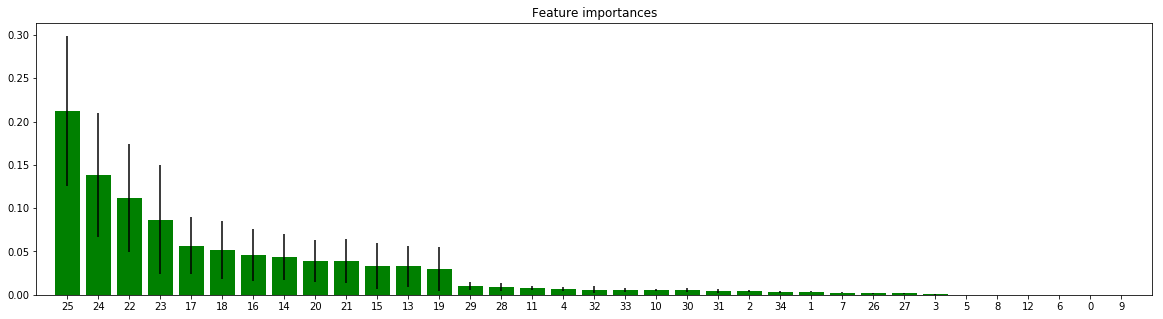


Decode features from ExtraTreesClassifier:
0 pitch_type_AB
1 pitch_type_CH
2 pitch_type_CU
3 pitch_type_EP
4 pitch_type_FF
5 pitch_type_FO
6 pitch_type_IN
7 pitch_type_KN
8 pitch_type_PO
9 pitch_type_SC
10 pitch_type_SI
11 pitch_type_SL
12 pitch_type_UN
13 zone_1
14 zone_2
15 zone_3
16 zone_4
17 zone_5
18 zone_6
19 zone_7
20 zone_8
21 zone_9
22 zone_11
23 zone_12
24 zone_13
25 zone_14
26 inning_side_bottom
27 inning_side_top
28 p_throws_L
29 p_throws_R
30 stand_L
31 stand_R
32 Count_type_Ahead
33 Count_type_Behind
34 Count_type_Even

Results of logistic regression model

Variable of interest, log odds, odds:
interpretation is that if any one of these variables is 'on', there is an increase (+) or decrease (-) in likelihood of a good outcome. Remember that a 'good outcome' is encoded into a modified hitter_val where '1' signifies good, aka, a negative hitter-val

                     0                  1                  2
0        pitch_type_AB  [-0.911778778134]  [-0.598191140828]
1 

In [7]:
hv_model("rawdata_ML.csv", ['pitch_type','zone','inning_side','p_throws','stand','count','hv_binary'])

In [1]:
# show plots in the notebook
# inspiration from http://nbviewer.jupyter.org/gist/justmarkham/6d5c061ca5aee67c4316471f8c2ae976
%matplotlib inline

Text(0,0.5,'Frequency')

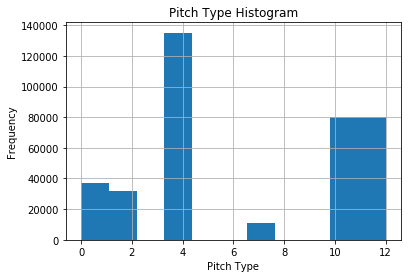

In [10]:
X_encoded.pitch_type.hist(bins=11)
plt.title('Pitch Type Histogram')
plt.xlabel('Pitch Type')
plt.ylabel('Frequency')

#interesting that some pitch types are very rare compared to others